# Object counting
In this notebook, we will learn how to count objects in images. There are four main categories to approach this problem (ordered by the necessary effort needed for annotation):
- Semantic segmentation (e.g. U-nets): 
    - Each pixel is annotated which is painfully time consuming. Furthermore, semantic segmentation does not directly give us the count of objects.
- Object detection by bounding box annotations (e.g. YOLO-type models). 
    - Annotation still requires significant efforts. This approach struggles with highly overlapping objects. Also, there are types of objects geometries that are not particularly well suited to be annotated by rectangular boxes.
- Object counting by density map estimation:
    - Each object is only annotated by a single-pixel dot. The annotations are then transformed into a density map and a model learns to predict these density maps. The count is subsequently derived from the integral of pixel values of the density maps. 
- Counting by direct regression:
    - A model directly learns to predict the count from an image. This requires no annotation other than the count. However, this does not really always work and it also remains unclear what the model has actually learned during training.

This notebook is concerned with object counting by density map estimation. We will work with a data set of microscopy images and the task is to count cells from these images. The dataset can be found here:
- Lempitsky and Zisserman: https://www.robots.ox.ac.uk/~vgg/research/counting/index_org.html

Also see the this research paper related to this data set:
- Xie, Noble and Zisserman: [Microscopy cell counting and detection with fully convolutional regression networks](https://www.robots.ox.ac.uk/~vgg/publications/2015/Xie15/weidi15.pdf)

Let's load the data set and get an idea of the available images and annotations:

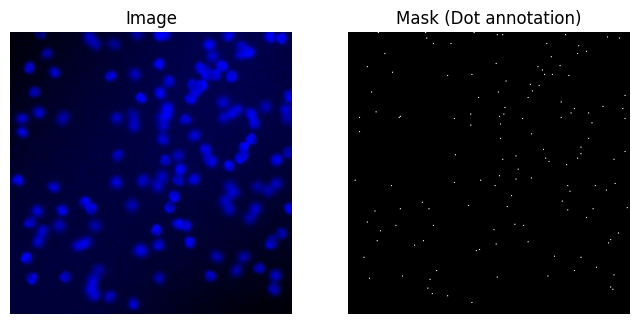

In [1]:
import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
import urllib
import zipfile
from PIL import Image, ImageOps
import os
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import NoNorm
import tensorflow as tf
from extras.unet import create_attention_res_u_net_model
from tensorflow.keras import callbacks
from tensorflow.keras.losses import MeanSquaredError
import random
from sklearn.metrics import mean_absolute_percentage_error
from scipy.stats import linregress
import warnings
seed = 42
random.seed(seed)

url = "https://www.robots.ox.ac.uk/~vgg/research/counting/cells.zip"
data_dir = "./data"

zip_path, _ = urllib.request.urlretrieve(url)
with zipfile.ZipFile(zip_path, "r") as f:
    f.extractall(data_dir)
     
files = next(os.walk(data_dir))[2]
files_X = [x for x in files if "cell" in x]
files_y = [x for x in files if "dots" in x]

X = np.zeros((len(files_X), 256, 256, 3), dtype="uint8")
for idx, file in enumerate(files_X):
    X[idx] = np.array(Image.open(data_dir + "/" + file))

y_masks = np.zeros((len(files_y), 256, 256))
for idx, file in enumerate(files_y):
    y_masks[idx] = np.array(
        ImageOps.grayscale(Image.open(data_dir + "/" + file)))
y_masks = np.where(y_masks > 0, 1, 0)
y_counts = np.sum(y_masks, axis=(1,2))

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(X[0])
ax[0].set_title("Image")
ax[1].imshow(y_masks[0], cmap="gray")
ax[1].set_title("Mask (Dot annotation)")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

We will put a frame of black pixels arount the images. We do this to avoid loss of information at the image borders for the density maps that we will create in the next step:

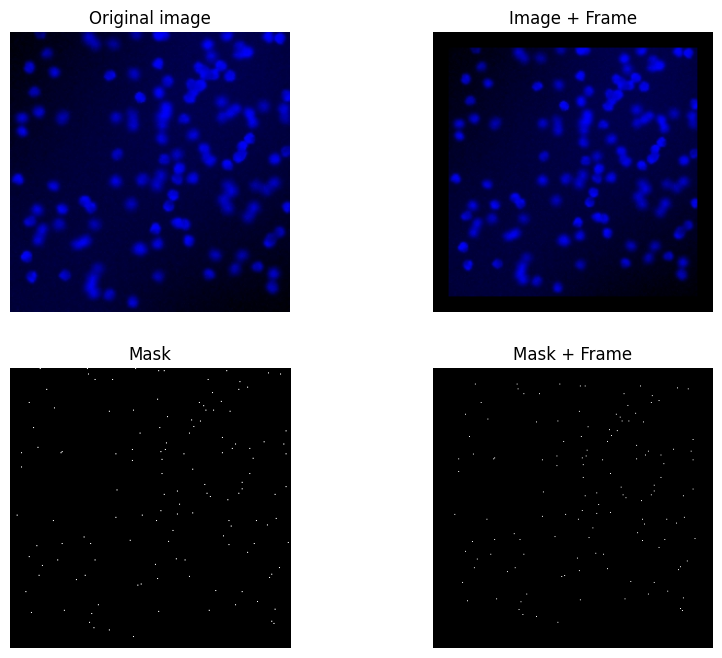

In [2]:
def frame_images(images, border_px):
    """
    Places a frame of black pixels around an image array.
    
    Parameters
    ----------
    images : numpy.array
        Image array of shape: (number of images, heigth, width, 
                               number of channels)
    border_px : int
        Number of pixel of the frame

    Returns
    -------
    images_w_border : numpy.array
        Image array with added frame.

    """
    shape = list(images.shape)
    shape[1] = shape[1] + border_px * 2
    shape[2] = shape[2] + border_px * 2
    images_w_border = np.zeros(tuple(shape), dtype="uint8")
    for idx, image in enumerate(images):
        images_w_border[idx] = np.array(
            ImageOps.expand(Image.fromarray(image), border_px, fill="black"))
    return images_w_border
        

X_framed = frame_images(X, 16).astype(np.float32) / 255
y_masks_framed = frame_images(y_masks, 16)

fig, ax = plt.subplots(2, 2, figsize=(10, 8))
ax[0,0].imshow(X[0])
ax[0,0].set_title("Original image")
ax[0,1].imshow(X_framed[0])
ax[0,1].set_title("Image + Frame")
ax[1,0].imshow(y_masks[0], cmap="gray")
ax[1,0].set_title("Mask")
ax[1,1].imshow(y_masks_framed[0], cmap="gray")
ax[1,1].set_title("Mask + Frame")
[axi.set_axis_off() for axi in ax.ravel()]
# plt.tight_layout()
plt.show()

Now, we will convert the dot annotations into density maps by calculating a Gauss function for each dot annotation. The standard deviation of the Gauss function is obviously a hyperparameter in this approach:

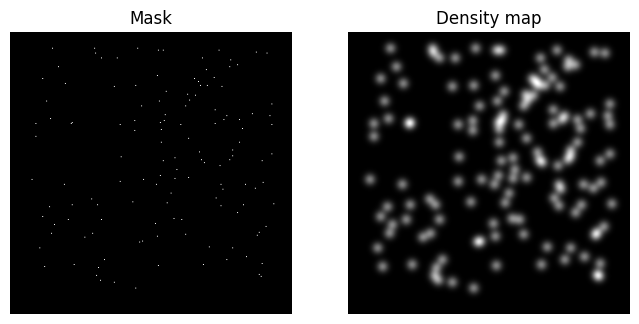

In [3]:
def create_densitiy_maps(masks, sigma):
    """
    Creates a density map from a mask of point annotations.

    Parameters
    ----------
    masks : numpy.array
        Image array of shape: (no. of images, heigth, width). Single-channel
    sigma : float
        standard deviation of gauss distribution


    Returns
    -------
    densitiy_maps : numpy.array
        Density maps as image array of shape: (no. of images, heigth, width).

    """
    densitiy_maps = np.zeros_like(masks, dtype=np.float32)
    x, y = range(masks.shape[2]), range(masks.shape[1])
    Xg, Yg = np.meshgrid(x, y)
    
    for idx, mask in enumerate(masks):
        peaks = np.where(mask != 0)
        for (y0, x0) in zip(peaks[0], peaks[1]):
            densitiy_maps[idx] = densitiy_maps[idx] + (
                np.exp(-(Xg - x0)**2 / (2 * sigma**2) - (Yg - y0)**2 / 
                       (2 * sigma**2)))
    return densitiy_maps


y_dm = np.expand_dims(create_densitiy_maps(y_masks_framed, 4), 3)

fig, ax = plt.subplots(1, 2, figsize=(8, 6))
ax[0].imshow(y_masks_framed[0], cmap="gray")
ax[0].set_title("Mask")
ax[1].imshow(y_dm[0], cmap="gray")
ax[1].set_title("Density map")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()

Then, we split the data into train, validation, and test set and scale the density maps:

In [4]:
def split_data(X, y_dm, y_counts, train_ratio, val_ratio):
    test_ratio = 1 - train_ratio - val_ratio
    idx_train = random.sample(range(X.shape[0]), int(X.shape[0] * train_ratio))
    idx_val = [x for x in range(X.shape[0]) if x not in idx_train]
    idx_test = random.sample(idx_val, int(X.shape[0] * test_ratio))
    idx_val = [x for x in idx_val if x not in idx_test]
    
    X_train, y_train_dm, y_train_counts = (
        X[idx_train], y_dm[idx_train], y_counts[idx_train])
    X_val, y_val_dm, y_val_counts = (
        X[idx_val], y_dm[idx_val], y_counts[idx_val])
    X_test, y_test_dm, y_test_counts = (
        X[idx_test], y_dm[idx_test], y_counts[idx_test])
    return (X_train, X_val, X_test, y_train_dm, y_val_dm, 
            y_test_dm, y_train_counts, y_val_counts, y_test_counts)


class MinMaxScaler:
    def fit(self, images):
        self.min = np.min(images)
        self.max = np.max(images)
    
    def transform(self, images):
        images_scaled = np.zeros_like(images)
        for idx, image in enumerate(images):
            images_scaled[idx] = (image - self.min) / (self.max - self.min)
        return images_scaled
    
    def fit_transform(self, images):
        self.fit(images)
        return self.transform(images)
    
    
(X_train, X_val, X_test, y_train_dm, y_val_dm, y_test_dm, y_train_counts, 
 y_val_counts, y_test_counts) = split_data(X_framed, y_dm, y_counts, 0.6, 0.25)

scaler = MinMaxScaler()
y_train_dm_scaled = scaler.fit_transform(y_train_dm)
y_val_dm_scaled = scaler.transform(y_val_dm)
y_test_dm_scaled = scaler.transform(y_test_dm)

Side note: If you want to know more about U-nets, please also see this notebook: 
https://github.com/cstckr/semantic_segmentation_u-net/blob/main/attention-res-u-net.ipynb

Now, we will train a U-net to predict the density maps from the input images:

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 288, 3  0           []                               
                                )]                                                                
                                                                                                  
 batch_normalization (BatchNorm  (None, 288, 288, 3)  12         ['input_1[0][0]']                
 alization)                                                                                       
                                                                                                  
 conv2d (Conv2D)                (None, 288, 288, 16  448         ['batch_normalization[0][0]']    
                                )                                                             

                                                                                                  
 batch_normalization_7 (BatchNo  (None, 36, 36, 128)  512        ['conv2d_9[0][0]']               
 rmalization)                                                                                     
                                                                                                  
 activation_10 (Activation)     (None, 36, 36, 128)  0           ['batch_normalization_7[0][0]']  
                                                                                                  
 activation_11 (Activation)     (None, 36, 36, 64)   0           ['batch_normalization_6[0][0]']  
                                                                                                  
 conv2d_10 (Conv2D)             (None, 36, 36, 128)  147584      ['activation_10[0][0]']          
                                                                                                  
 conv2d_11

                                                                                                  
 up_sampling2d_3 (UpSampling2D)  (None, 144, 144, 1)  0          ['batch_normalization_16[0][0]'] 
                                                                                                  
 multiply_1 (Multiply)          (None, 144, 144, 32  0           ['add_1[0][0]',                  
                                )                                 'up_sampling2d_3[0][0]']        
                                                                                                  
 up_sampling2d_2 (UpSampling2D)  (None, 144, 144, 64  0          ['add_5[0][0]']                  
                                )                                                                 
                                                                                                  
 batch_normalization_17 (BatchN  (None, 144, 144, 32  128        ['multiply_1[0][0]']             
 ormalizat

                                )                                                                 
                                                                                                  
 batch_normalization_25 (BatchN  (None, 288, 288, 16  64         ['conv2d_27[0][0]']              
 ormalization)                  )                                                                 
                                                                                                  
 activation_22 (Activation)     (None, 288, 288, 16  0           ['batch_normalization_25[0][0]'] 
                                )                                                                 
                                                                                                  
 activation_23 (Activation)     (None, 288, 288, 48  0           ['batch_normalization_24[0][0]'] 
                                )                                                                 
          

INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 115s 14s/step - loss: 4.3028 - val_loss: 660819.1875 - lr: 0.0070
Epoch 2/125
8/8 [==============================] - ETA: 0s - loss: 0.1791INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 107s 14s/step - loss: 0.1791 - val_loss: 132964.6250 - lr: 0.0069
Epoch 3/125
8/8 [==============================] - ETA: 0s - loss: 0.0588INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 106s 14s/step - loss: 0.0588 - val_loss: 10291.0391 - lr: 0.0069
Epoch 4/125
8/8 [==============================] - ETA: 0s - loss: 0.0306INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0306 - val_loss: 781.6069 - lr: 0.0069
Epoch 5/125
8/8 [==============================] - ETA: 0s - loss: 0.0184INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 108s 14s/step - loss: 0.0184 - val_loss: 32.9082 - lr: 0.0068
Epoch 6/125
8/8 [==============================] - ETA: 0s - loss: 0.0126INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0126 - val_loss: 3.2635 - lr: 0.0068
Epoch 7/125
8/8 [==============================] - 80s 10s/step - loss: 0.0092 - val_loss: 3.9423 - lr: 0.0068
Epoch 8/125
8/8 [==============================] - ETA: 0s - loss: 0.0079INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 106s 14s/step - loss: 0.0079 - val_loss: 0.5773 - lr: 0.0067
Epoch 9/125
8/8 [==============================] - ETA: 0s - loss: 0.0067INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0067 - val_loss: 0.2011 - lr: 0.0067
Epoch 10/125
8/8 [==============================] - ETA: 0s - loss: 0.0059INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 103s 13s/step - loss: 0.0059 - val_loss: 0.1406 - lr: 0.0067
Epoch 11/125
8/8 [==============================] - ETA: 0s - loss: 0.0055INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0055 - val_loss: 0.1135 - lr: 0.0066
Epoch 12/125
8/8 [==============================] - ETA: 0s - loss: 0.0051INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0051 - val_loss: 0.0897 - lr: 0.0066
Epoch 13/125
8/8 [==============================] - ETA: 0s - loss: 0.0048INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0048 - val_loss: 0.0653 - lr: 0.0066
Epoch 14/125
8/8 [==============================] - ETA: 0s - loss: 0.0044INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0044 - val_loss: 0.0449 - lr: 0.0065
Epoch 15/125
8/8 [==============================] - ETA: 0s - loss: 0.0042INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0042 - val_loss: 0.0312 - lr: 0.0065
Epoch 16/125
8/8 [==============================] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0040 - val_loss: 0.0226 - lr: 0.0065
Epoch 17/125
8/8 [==============================] - ETA: 0s - loss: 0.0040INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0040 - val_loss: 0.0173 - lr: 0.0064
Epoch 18/125
8/8 [==============================] - ETA: 0s - loss: 0.0037INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0037 - val_loss: 0.0138 - lr: 0.0064
Epoch 19/125
8/8 [==============================] - ETA: 0s - loss: 0.0036INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0036 - val_loss: 0.0111 - lr: 0.0064
Epoch 20/125
8/8 [==============================] - ETA: 0s - loss: 0.0034INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 103s 13s/step - loss: 0.0034 - val_loss: 0.0100 - lr: 0.0063
Epoch 21/125
8/8 [==============================] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0033 - val_loss: 0.0087 - lr: 0.0063
Epoch 22/125
8/8 [==============================] - ETA: 0s - loss: 0.0033INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0033 - val_loss: 0.0076 - lr: 0.0063
Epoch 23/125
8/8 [==============================] - ETA: 0s - loss: 0.0032INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0032 - val_loss: 0.0066 - lr: 0.0062
Epoch 24/125
8/8 [==============================] - ETA: 0s - loss: 0.0031INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0031 - val_loss: 0.0064 - lr: 0.0062
Epoch 25/125
8/8 [==============================] - 79s 10s/step - loss: 0.0029 - val_loss: 0.0066 - lr: 0.0062
Epoch 26/125
8/8 [==============================] - ETA: 0s - loss: 0.0028INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 103s 13s/step - loss: 0.0028 - val_loss: 0.0058 - lr: 0.0061
Epoch 27/125
8/8 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0027 - val_loss: 0.0054 - lr: 0.0061
Epoch 28/125
8/8 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 103s 13s/step - loss: 0.0027 - val_loss: 0.0051 - lr: 0.0061
Epoch 29/125
8/8 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0027 - val_loss: 0.0048 - lr: 0.0061
Epoch 30/125
8/8 [==============================] - ETA: 0s - loss: 0.0027INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 103s 13s/step - loss: 0.0027 - val_loss: 0.0041 - lr: 0.0060
Epoch 31/125
8/8 [==============================] - 79s 10s/step - loss: 0.0026 - val_loss: 0.0041 - lr: 0.0060
Epoch 32/125
8/8 [==============================] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0025 - val_loss: 0.0039 - lr: 0.0060
Epoch 33/125
8/8 [==============================] - ETA: 0s - loss: 0.0025INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0025 - val_loss: 0.0035 - lr: 0.0059
Epoch 34/125
8/8 [==============================] - 80s 10s/step - loss: 0.0024 - val_loss: 0.0036 - lr: 0.0059
Epoch 35/125
8/8 [==============================] - 79s 10s/step - loss: 0.0023 - val_loss: 0.0039 - lr: 0.0059
Epoch 36/125
8/8 [==============================] - ETA: 0s - loss: 0.0024INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0024 - val_loss: 0.0032 - lr: 0.0058
Epoch 37/125
8/8 [==============================] - ETA: 0s - loss: 0.0023INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0023 - val_loss: 0.0031 - lr: 0.0058
Epoch 38/125
8/8 [==============================] - ETA: 0s - loss: 0.0023INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0023 - val_loss: 0.0026 - lr: 0.0058
Epoch 39/125
8/8 [==============================] - 81s 10s/step - loss: 0.0022 - val_loss: 0.0028 - lr: 0.0058
Epoch 40/125
8/8 [==============================] - ETA: 0s - loss: 0.0022INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 105s 14s/step - loss: 0.0022 - val_loss: 0.0021 - lr: 0.0057
Epoch 41/125
8/8 [==============================] - 81s 10s/step - loss: 0.0024 - val_loss: 0.0029 - lr: 0.0057
Epoch 42/125
8/8 [==============================] - 90s 12s/step - loss: 0.0022 - val_loss: 0.0027 - lr: 0.0057
Epoch 43/125
8/8 [==============================] - 85s 11s/step - loss: 0.0022 - val_loss: 0.0027 - lr: 0.0056
Epoch 44/125
8/8 [==============================] - ETA: 0s - loss: 0.0022 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 117s 15s/step - loss: 0.0022 - val_loss: 0.0019 - lr: 0.0056
Epoch 45/125
8/8 [==============================] - ETA: 0s - loss: 0.0021 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 110s 14s/step - loss: 0.0021 - val_loss: 0.0019 - lr: 0.0056
Epoch 46/125
8/8 [==============================] - ETA: 0s - loss: 0.0020INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 106s 14s/step - loss: 0.0020 - val_loss: 0.0018 - lr: 0.0056
Epoch 47/125
8/8 [==============================] - 79s 10s/step - loss: 0.0019 - val_loss: 0.0019 - lr: 0.0055
Epoch 48/125
8/8 [==============================] - 78s 10s/step - loss: 0.0019 - val_loss: 0.0018 - lr: 0.0055
Epoch 49/125
8/8 [==============================] - ETA: 0s - loss: 0.0019 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 108s 14s/step - loss: 0.0019 - val_loss: 0.0018 - lr: 0.0055
Epoch 50/125
8/8 [==============================] - ETA: 0s - loss: 0.0019INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 108s 14s/step - loss: 0.0019 - val_loss: 0.0017 - lr: 0.0054
Epoch 51/125
8/8 [==============================] - ETA: 0s - loss: 0.0018 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 110s 14s/step - loss: 0.0018 - val_loss: 0.0016 - lr: 0.0054
Epoch 52/125
8/8 [==============================] - 85s 11s/step - loss: 0.0018 - val_loss: 0.0017 - lr: 0.0054
Epoch 53/125
8/8 [==============================] - ETA: 0s - loss: 0.0019 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 113s 15s/step - loss: 0.0019 - val_loss: 0.0015 - lr: 0.0054
Epoch 54/125
8/8 [==============================] - 83s 11s/step - loss: 0.0019 - val_loss: 0.0018 - lr: 0.0053
Epoch 55/125
8/8 [==============================] - ETA: 0s - loss: 0.0018INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 106s 14s/step - loss: 0.0018 - val_loss: 0.0014 - lr: 0.0053
Epoch 56/125
8/8 [==============================] - 80s 10s/step - loss: 0.0018 - val_loss: 0.0015 - lr: 0.0053
Epoch 57/125
8/8 [==============================] - 81s 10s/step - loss: 0.0018 - val_loss: 0.0015 - lr: 0.0053
Epoch 58/125
8/8 [==============================] - 82s 10s/step - loss: 0.0017 - val_loss: 0.0015 - lr: 0.0052
Epoch 59/125
8/8 [==============================] - ETA: 0s - loss: 0.0019 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 115s 15s/step - loss: 0.0019 - val_loss: 0.0014 - lr: 0.0052
Epoch 60/125
8/8 [==============================] - 86s 11s/step - loss: 0.0018 - val_loss: 0.0014 - lr: 0.0052
Epoch 61/125
8/8 [==============================] - ETA: 0s - loss: 0.0017 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 121s 16s/step - loss: 0.0017 - val_loss: 0.0014 - lr: 0.0052
Epoch 62/125
8/8 [==============================] - 86s 11s/step - loss: 0.0017 - val_loss: 0.0015 - lr: 0.0051
Epoch 63/125
8/8 [==============================] - ETA: 0s - loss: 0.0016 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 112s 14s/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0051
Epoch 64/125
8/8 [==============================] - 84s 11s/step - loss: 0.0016 - val_loss: 0.0015 - lr: 0.0051
Epoch 65/125
8/8 [==============================] - 83s 10s/step - loss: 0.0017 - val_loss: 0.0015 - lr: 0.0051
Epoch 66/125
8/8 [==============================] - 84s 11s/step - loss: 0.0016 - val_loss: 0.0016 - lr: 0.0050
Epoch 67/125
8/8 [==============================] - 82s 10s/step - loss: 0.0018 - val_loss: 0.0015 - lr: 0.0050
Epoch 68/125
8/8 [==============================] - ETA: 0s - loss: 0.0016INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 106s 14s/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0050
Epoch 69/125
8/8 [==============================] - 85s 11s/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0050
Epoch 70/125
8/8 [==============================] - ETA: 0s - loss: 0.0016 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 111s 14s/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0049
Epoch 71/125
8/8 [==============================] - 81s 10s/step - loss: 0.0017 - val_loss: 0.0013 - lr: 0.0049
Epoch 72/125
8/8 [==============================] - 83s 10s/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0049
Epoch 73/125
8/8 [==============================] - 81s 10s/step - loss: 0.0015 - val_loss: 0.0013 - lr: 0.0049
Epoch 74/125
8/8 [==============================] - ETA: 0s - loss: 0.0015 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 111s 14s/step - loss: 0.0015 - val_loss: 0.0013 - lr: 0.0048
Epoch 75/125
8/8 [==============================] - 84s 11s/step - loss: 0.0015 - val_loss: 0.0013 - lr: 0.0048
Epoch 76/125
8/8 [==============================] - 96s 12s/step - loss: 0.0016 - val_loss: 0.0016 - lr: 0.0048
Epoch 77/125
8/8 [==============================] - 85s 11s/step - loss: 0.0019 - val_loss: 0.0013 - lr: 0.0048
Epoch 78/125
8/8 [==============================] - 83s 10s/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0047
Epoch 79/125
8/8 [==============================] - 83s 10s/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0047
Epoch 80/125
8/8 [==============================] - 82s 10s/step - loss: 0.0015 - val_loss: 0.0015 - lr: 0.0047
Epoch 81/125
8/8 [==============================] - 82s 10s/step - loss: 0.0017 - val_loss: 0.0014 - lr: 0.0047
Epoch 82/125
8/8 [==============================] - 85s 11s/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0046
Epoc

INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 119s 15s/step - loss: 0.0015 - val_loss: 0.0012 - lr: 0.0046
Epoch 84/125
8/8 [==============================] - 83s 10s/step - loss: 0.0016 - val_loss: 0.0017 - lr: 0.0046
Epoch 85/125
8/8 [==============================] - 90s 11s/step - loss: 0.0017 - val_loss: 0.0014 - lr: 0.0046
Epoch 86/125
8/8 [==============================] - ETA: 0s - loss: 0.0015 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 119s 15s/step - loss: 0.0015 - val_loss: 0.0012 - lr: 0.0045
Epoch 87/125
8/8 [==============================] - 89s 11s/step - loss: 0.0015 - val_loss: 0.0012 - lr: 0.0045
Epoch 88/125
8/8 [==============================] - 84s 10s/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0045
Epoch 89/125
8/8 [==============================] - ETA: 0s - loss: 0.0014 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 112s 15s/step - loss: 0.0014 - val_loss: 0.0011 - lr: 0.0045
Epoch 90/125
8/8 [==============================] - 85s 11s/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0045
Epoch 91/125
8/8 [==============================] - 83s 10s/step - loss: 0.0014 - val_loss: 0.0011 - lr: 0.0044
Epoch 92/125
8/8 [==============================] - ETA: 0s - loss: 0.0013 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 110s 14s/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0044
Epoch 93/125
8/8 [==============================] - 83s 10s/step - loss: 0.0014 - val_loss: 0.0012 - lr: 0.0044
Epoch 94/125
8/8 [==============================] - 81s 10s/step - loss: 0.0015 - val_loss: 0.0014 - lr: 0.0044
Epoch 95/125
8/8 [==============================] - 88s 11s/step - loss: 0.0016 - val_loss: 0.0014 - lr: 0.0043
Epoch 96/125
8/8 [==============================] - 83s 10s/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0043
Epoch 97/125
8/8 [==============================] - 81s 10s/step - loss: 0.0015 - val_loss: 0.0012 - lr: 0.0043
Epoch 98/125
8/8 [==============================] - 83s 10s/step - loss: 0.0016 - val_loss: 0.0013 - lr: 0.0043
Epoch 99/125
8/8 [==============================] - 85s 11s/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0043
Epoch 100/125
8/8 [==============================] - 84s 10s/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0042
Epo

INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 107s 14s/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0042
Epoch 105/125
8/8 [==============================] - ETA: 0s - loss: 0.0013 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 108s 14s/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0041
Epoch 106/125
8/8 [==============================] - 84s 11s/step - loss: 0.0013 - val_loss: 0.0012 - lr: 0.0041
Epoch 107/125
8/8 [==============================] - 82s 10s/step - loss: 0.0015 - val_loss: 0.0012 - lr: 0.0041
Epoch 108/125
8/8 [==============================] - 83s 11s/step - loss: 0.0014 - val_loss: 0.0013 - lr: 0.0041
Epoch 109/125
8/8 [==============================] - ETA: 0s - loss: 0.0013 INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 109s 14s/step - loss: 0.0013 - val_loss: 0.0010 - lr: 0.0041
Epoch 110/125
8/8 [==============================] - 83s 10s/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0040
Epoch 111/125
8/8 [==============================] - 82s 10s/step - loss: 0.0014 - val_loss: 0.0011 - lr: 0.0040
Epoch 112/125
8/8 [==============================] - 80s 10s/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0040
Epoch 113/125
8/8 [==============================] - 79s 10s/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0040
Epoch 114/125
8/8 [==============================] - 79s 10s/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0040
Epoch 115/125
8/8 [==============================] - 79s 10s/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0039
Epoch 116/125
8/8 [==============================] - 80s 10s/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0039
Epoch 117/125
8/8 [==============================] - 79s 10s/step - loss: 0.0013 - val_loss: 0.0013 - lr: 0.0

INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 14s/step - loss: 0.0013 - val_loss: 0.0010 - lr: 0.0039
Epoch 119/125
8/8 [==============================] - 79s 10s/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0039
Epoch 120/125
8/8 [==============================] - ETA: 0s - loss: 0.0013INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 104s 13s/step - loss: 0.0013 - val_loss: 0.0010 - lr: 0.0038
Epoch 121/125
8/8 [==============================] - ETA: 0s - loss: 0.0012INFO:tensorflow:Assets written to: .\unet1\assets


INFO:tensorflow:Assets written to: .\unet1\assets


8/8 [==============================] - 103s 13s/step - loss: 0.0012 - val_loss: 0.0010 - lr: 0.0038
Epoch 122/125
8/8 [==============================] - 79s 10s/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0038
Epoch 123/125
8/8 [==============================] - 79s 10s/step - loss: 0.0012 - val_loss: 0.0011 - lr: 0.0038
Epoch 124/125
8/8 [==============================] - 80s 10s/step - loss: 0.0012 - val_loss: 0.0012 - lr: 0.0038
Epoch 125/125
8/8 [==============================] - 79s 10s/step - loss: 0.0013 - val_loss: 0.0011 - lr: 0.0037


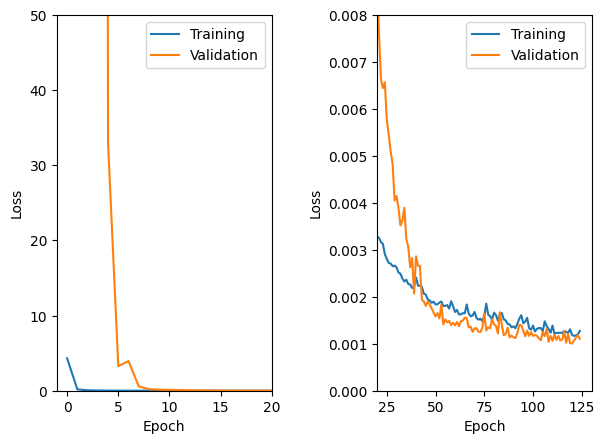

In [5]:
unet1 = create_attention_res_u_net_model(input_shape=(288, 288, 3), seed=seed)

def scheduler(epoch, lr): 
    return lr * 0.995


unet1.compile(optimizer=tf.keras.optimizers.Adam(
    learning_rate=0.007), 
    loss=MeanSquaredError())
cb1 = callbacks.EarlyStopping(
    monitor="val_loss", mode="min", verbose=1, patience=12)               
cb2 = callbacks.LearningRateScheduler(scheduler)
cb3 = callbacks.ModelCheckpoint(
    ".\\unet1", monitor="val_loss", save_best_only=True)

with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    history = unet1.fit(
        X_train, y_train_dm_scaled, 
        epochs=125, batch_size=16, 
        validation_data=(X_val, y_val_dm_scaled), shuffle=True, verbose=1, 
        callbacks=[cb1, cb2, cb3])
    
fig, ax = plt.subplots(1, 2)
for i in [0, 1]:
    ax[i].plot(history.history["loss"], label="Training")
    ax[i].plot(history.history["val_loss"], label="Validation")
    ax[i].set_xlabel("Epoch")
    ax[i].set_ylabel("Loss")
    ax[i].legend()   
ax[0].set_xlim(-1, 20)
ax[0].set_ylim(0, 50)
ax[1].set_xlim(20, )
ax[1].set_ylim(0, 0.008)
plt.tight_layout(pad=2.0)
plt.show()

After training, we will predict the density maps, inspect a single prediction and calculate the losses:

4/4 [==============================] - 16s 4s/step


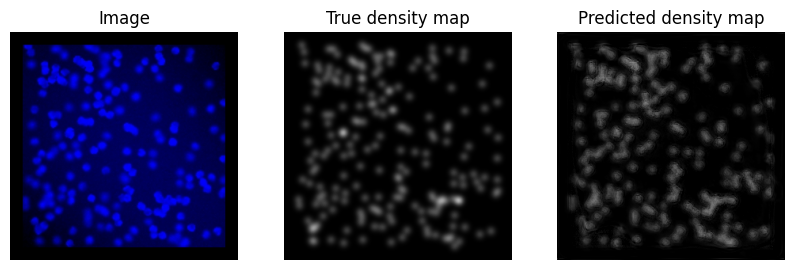

The mean squared error between actual and predicted density map for this particural image from the test set (idx: 1) is:
1.3699E-03
The mean squared error between actual and predicted density maps for all images in the test dataset is: 
 1.1350E-03


In [6]:
unet1 = tf.keras.models.load_model(".\\unet1", compile=False)

y_test_pred_dm = unet1.predict(X_test)
y_val_pred_dm = unet1.predict(X_val)
y_train_pred_dm = unet1.predict(X_train)

mse_loss = MeanSquaredError()

idx = 1
fig, ax = plt.subplots(1, 3, figsize=(10, 8))
ax[0].imshow(X_test[idx], cmap="gray")
ax[0].set_title("Image")
ax[1].imshow(y_test_dm_scaled[idx], cmap="gray", norm=NoNorm())
ax[1].set_title("True density map")
ax[2].imshow(y_test_pred_dm[idx], cmap="gray", norm=NoNorm())
ax[2].set_title("Predicted density map")
[axi.set_axis_off() for axi in ax.ravel()]
plt.show()
print(f"""The mean squared error between actual and predicted density map for this particural image from the test set (idx: {idx}) is:
{mse_loss(y_test_dm_scaled[idx], y_test_pred_dm[idx]).numpy():.4E}""")

print(f"""The mean squared error between actual and predicted density maps for all images in the test dataset is: 
{mse_loss(y_test_dm_scaled, y_test_pred_dm).numpy(): .4E}""")

We calculate the sum of all pixel values for the predicted density maps. From the training set, we can see that we can directly relate this sum to the count of objects:

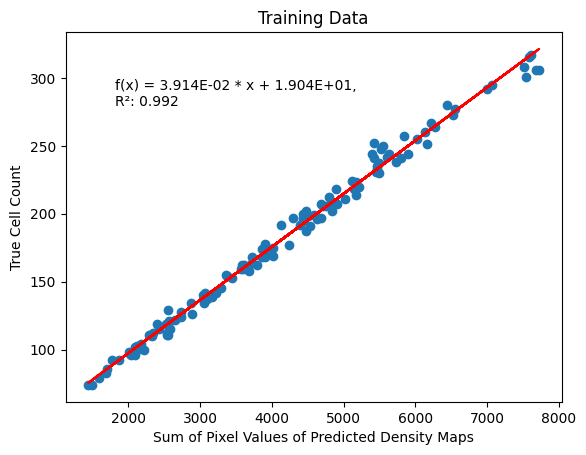

In [7]:
y_test_pred_dm_sum = np.sum(y_test_pred_dm, axis=(1, 2))
y_test_dm_sum = np.sum(y_test_dm_scaled, axis=(1, 2))

y_train_pred_dm_sum = np.sum(y_train_pred_dm, axis=(1, 2))
y_train_dm_sum = np.sum(y_train_dm_scaled, axis=(1, 2))

y_val_pred_dm_sum = np.sum(y_val_pred_dm, axis=(1, 2))
y_val_dm_sum = np.sum(y_val_dm_scaled, axis=(1, 2))

fig, ax = plt.subplots()
ax.scatter(y_train_pred_dm_sum, y_train_counts)
slope1, intercept1, r_value, _, _ = linregress(
    y_train_pred_dm_sum.flatten(), y_train_counts)
ax.plot(y_train_pred_dm_sum, (slope1 * y_train_pred_dm_sum + intercept1),
        color="red")
ax.set_xlabel("Sum of Pixel Values of Predicted Density Maps")
ax.set_ylabel("True Cell Count")
ax.text(0.1, 0.8, f"""f(x) = {slope1:.3E} * x + {intercept1:.3E}, 
R\u00b2: {r_value**2:.3f} """, transform=ax.transAxes)
ax.set_title("Training Data")
plt.show()

Finally, let's derive the predicted counts for the test set and compare them to the true counts:

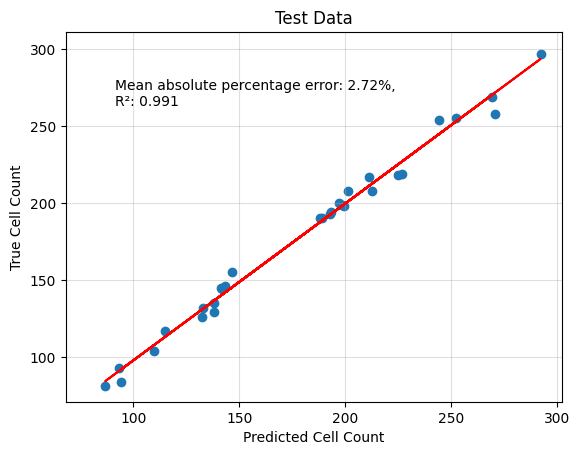

In [8]:
y_test_pred_counts = slope1 * y_test_pred_dm_sum + intercept1

fig, ax = plt.subplots()
ax.scatter(y_test_pred_counts, y_test_counts)
slope2, intercept2, r_value, _, _ = linregress(
    y_test_pred_counts.flatten(), y_test_counts)
ax.plot(y_test_pred_counts, (slope2 * y_test_pred_counts + intercept2),
        color="red")
ax.set_xlim(int(np.min([y_test_pred_counts.flatten(), y_test_counts])*0.85), 
            int(np.max([y_test_pred_counts.flatten(), y_test_counts])*1.02))
ax.set_ylim(int(np.min([y_test_pred_counts.flatten(), y_test_counts])*0.88), 
            int(np.max([y_test_pred_counts.flatten(), y_test_counts])*1.05))
ax.set_xlabel("Predicted Cell Count")
ax.set_ylabel("True Cell Count")
ax.text(0.1, 0.8, f"""Mean absolute percentage error: {mean_absolute_percentage_error(y_test_pred_counts, y_test_counts)*100:.2f}%, 
R\u00b2: {r_value**2:.3f} """, transform=ax.transAxes)
ax.set_title("Test Data")
plt.grid(alpha=0.4)
plt.show()